In [48]:
from Utils.Config import DATA_DIR
from Utils.Config import CHARTS_DIR
from Utils import dataUtils
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os

In [49]:
path = dataUtils.getDataPaths(2)
data = dataUtils.concat_dfs("prices", path)

<Axes: >

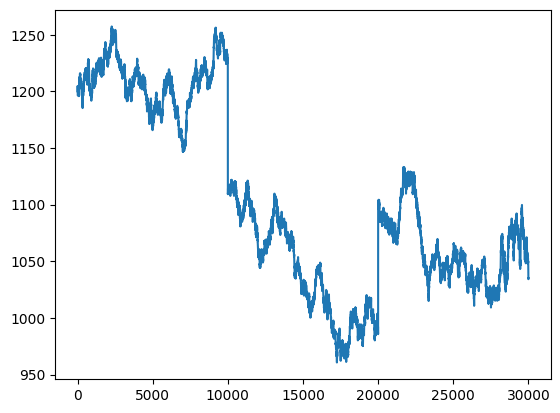

In [50]:
data["ORCHIDS"].plot()

Feature Analysis EDA

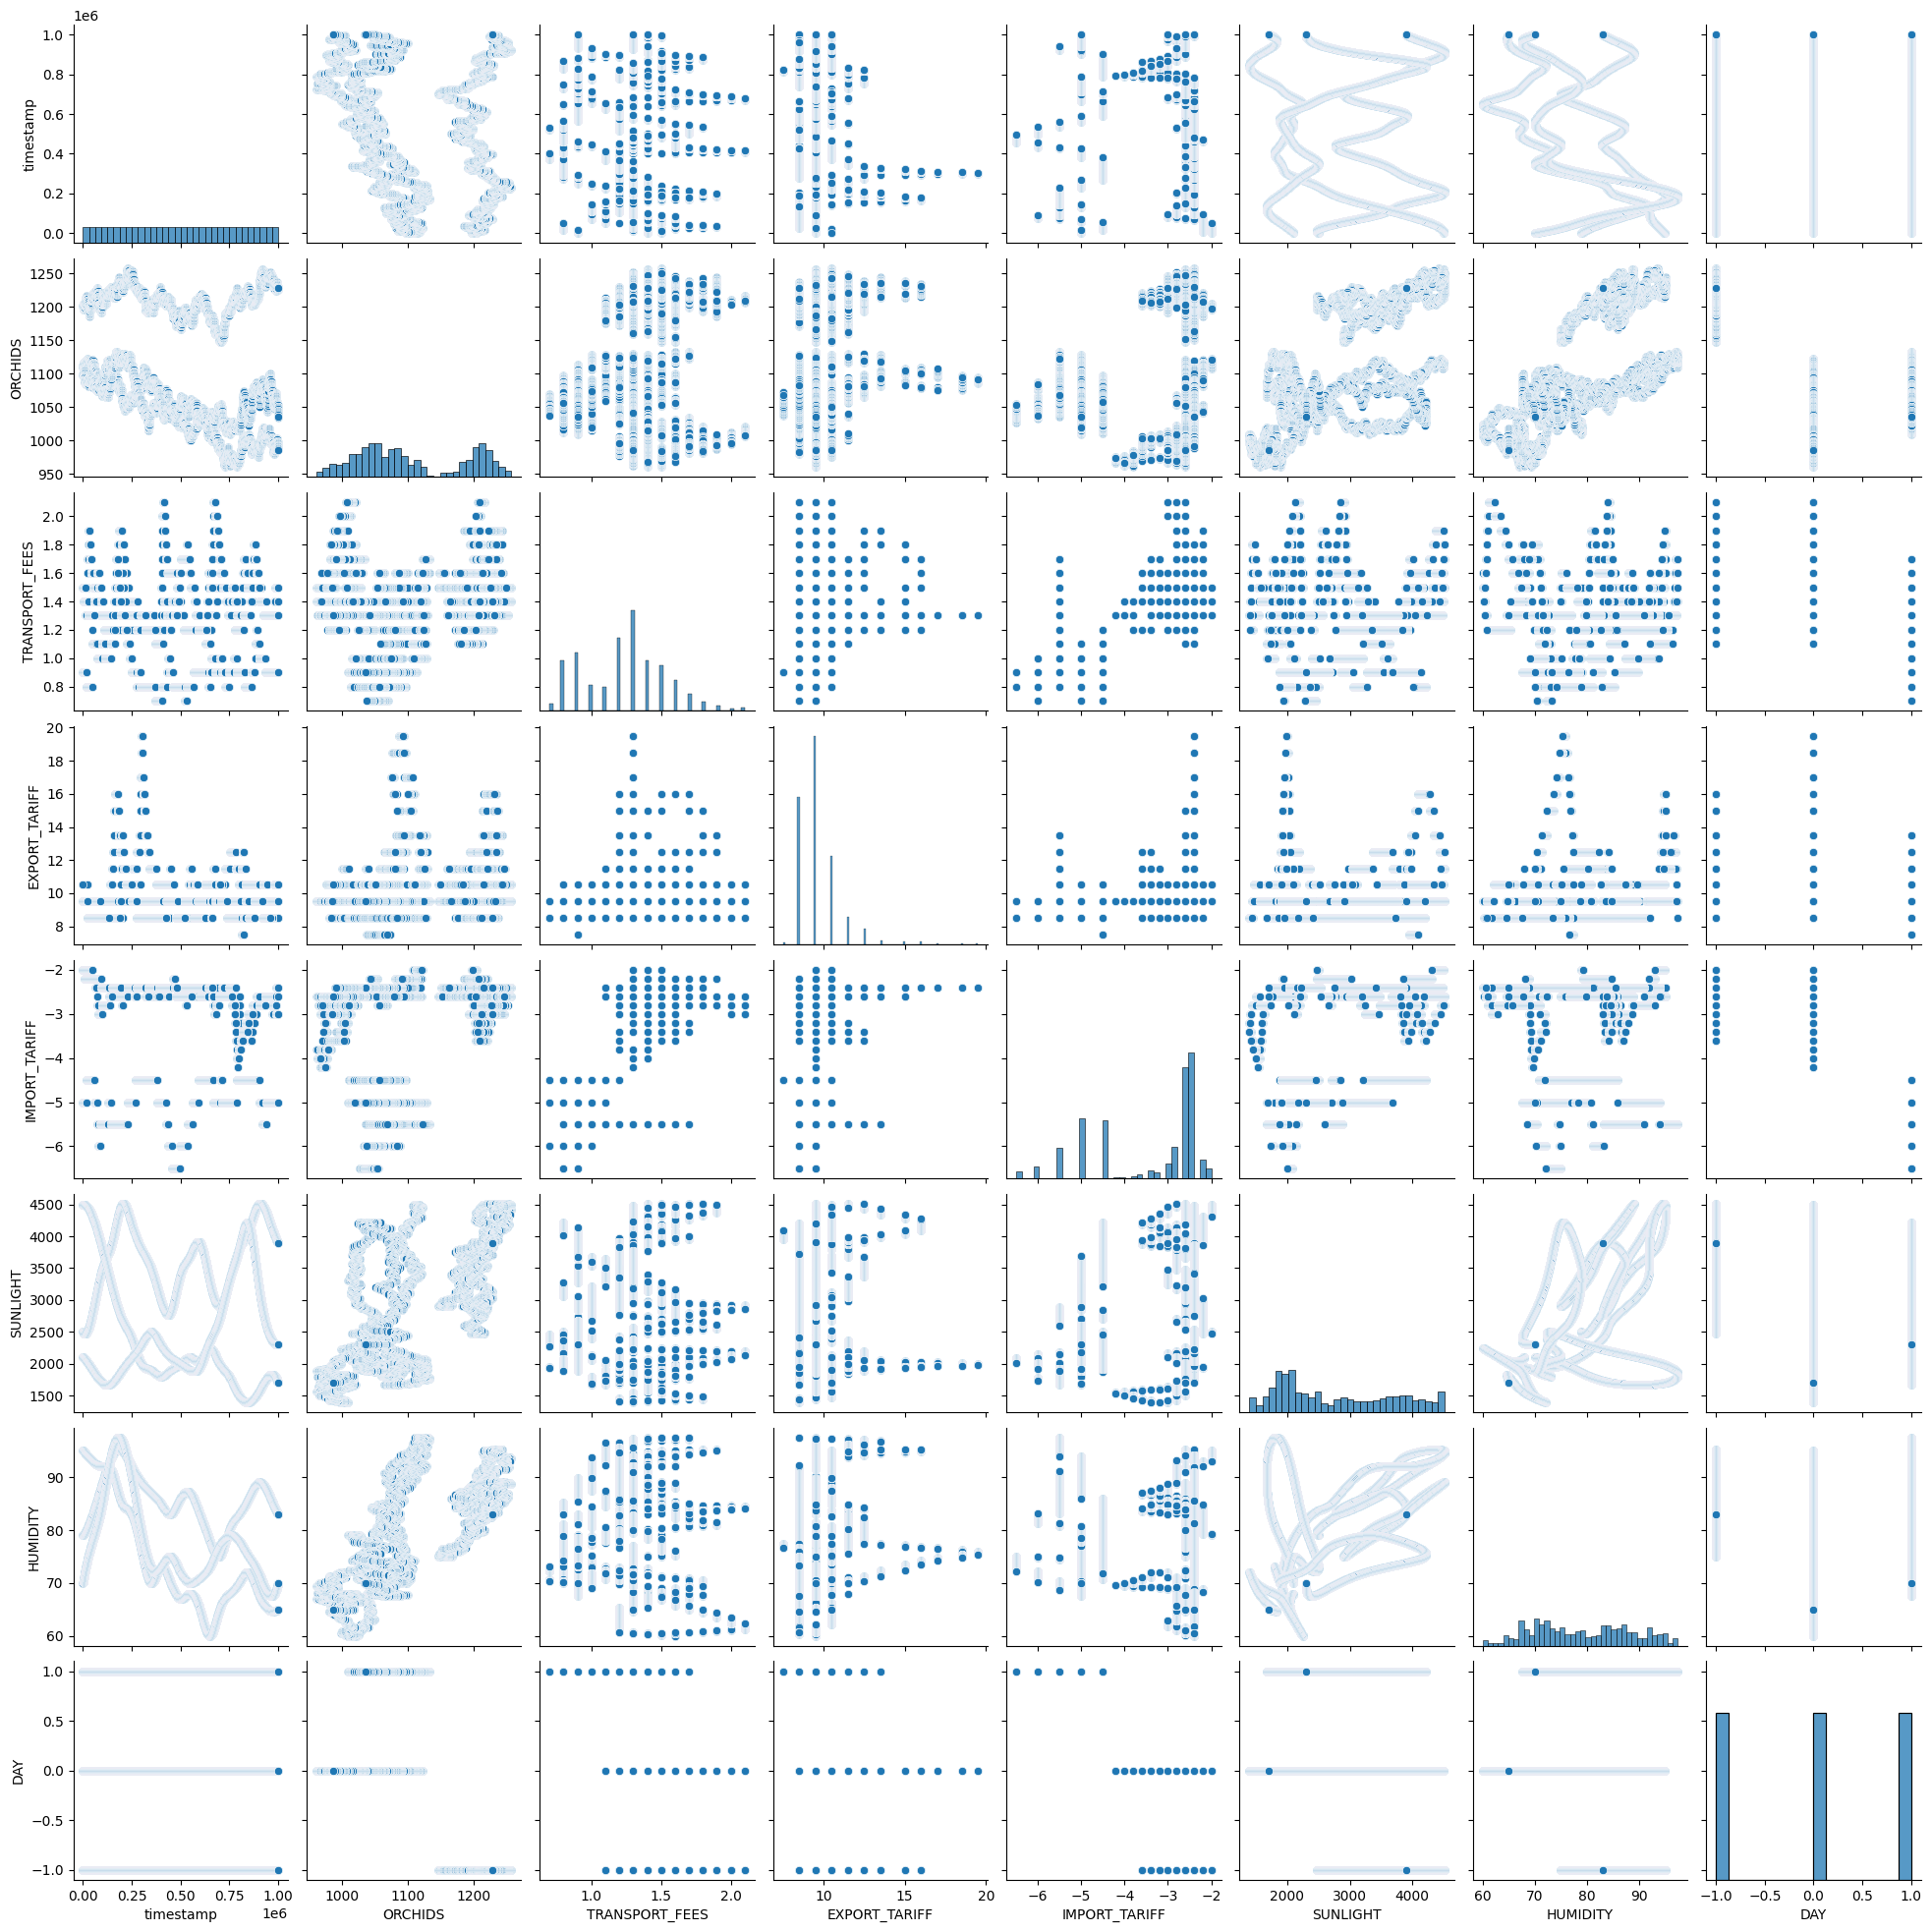

In [51]:
import seaborn as sns

features = ["ORCHIDS","TRANSPORT_FEES", "EXPORT_TARIFF", "IMPORT_TARIFF", "SUNLIGHT", "HUMIDITY"]
sns.pairplot(data)

Linear Regression Parameters to predict the price of orchids

In [52]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


data["ET"] = data["EXPORT_TARIFF"].rolling(100).mean()
data["TFees"] = data["TRANSPORT_FEES"].rolling(100).mean()
data["IT"] = data["IMPORT_TARIFF"].rolling(100).mean()
data["S"] = data["SUNLIGHT"].rolling(100).mean()
data["H"] = data["HUMIDITY"].rolling(100).mean()

data.dropna(inplace=True)

X = data[["TFees", "ET", "IT", "S", "H"]]
y = data["ORCHIDS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42,shuffle=False)
model = Lasso()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(mean_squared_error(y_test, preds))

7642.609415859025


[0.         5.15181966 0.48610288 0.05328593 2.73283965]


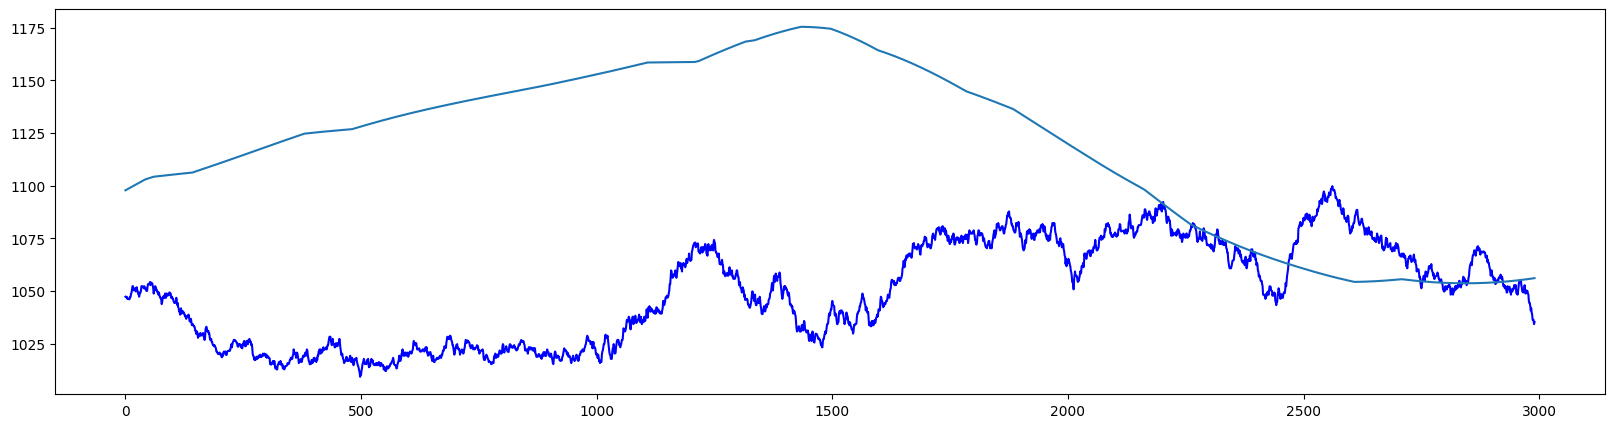

In [53]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.values, color="blue")
plt.plot(preds)

print(model.coef_)

Feature Enginering and Model Improvement

0.8115916351870148

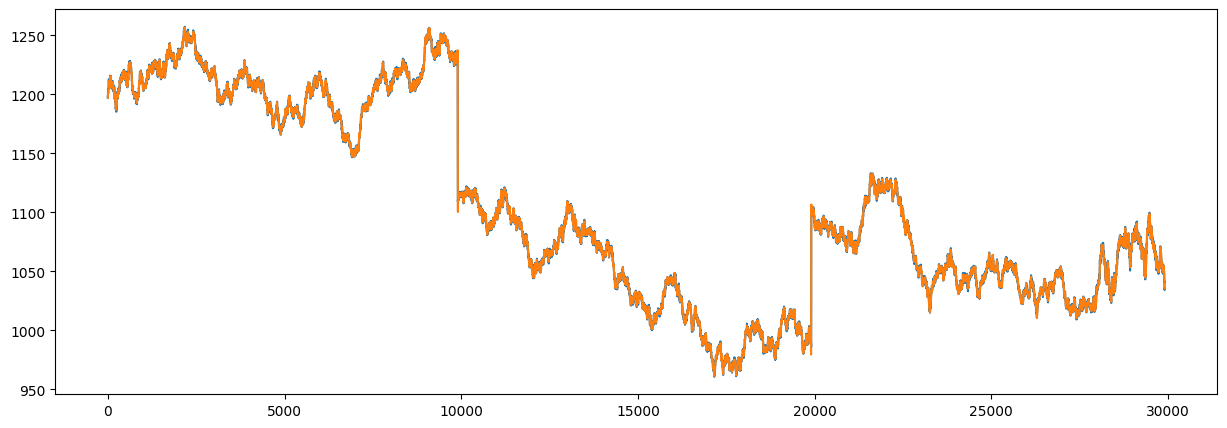

In [54]:
#Filtering ORCHIDS:

sig = data.ORCHIDS.values
window = 11
savgol_preds = dataUtils.savitzky_golay(sig,window,order=3)
fig = plt.figure(figsize=(15,5))
plt.plot(sig)
plt.plot(savgol_preds)

data["H_fil"] = sc.signal.savgol_filter(data.HUMIDITY, window_length=window, polyorder=4, mode="nearest")
data["S_fil"] = sc.signal.savgol_filter(data.SUNLIGHT, window_length=window, polyorder=4, mode="nearest")
data["savgol_price"] = savgol_preds
data["savgol_gradient"] = np.gradient(data.savgol_price)

data["ORCHIDS_SMA25"] = data["ORCHIDS"].rolling(25).mean()
data.dropna(inplace=True)

mean_squared_error(sig,savgol_preds)


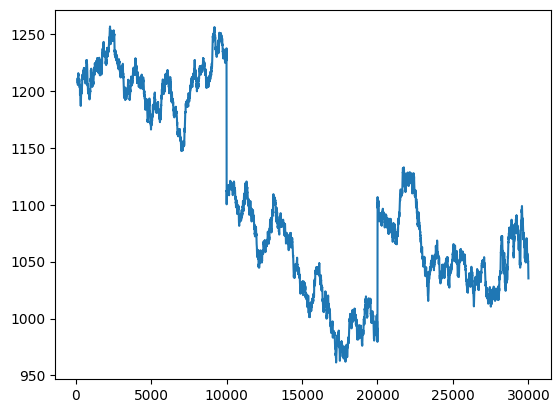

In [55]:
plt.plot(data.savgol_price)

In [56]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = data[["TRANSPORT_FEES", "EXPORT_TARIFF", "IMPORT_TARIFF", "SUNLIGHT", "HUMIDITY"]]
y = data["ORCHIDS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=False)
model = Lasso()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(mean_squared_error(y_test, preds))

5019.77217628947


[ 0.          4.59945269 -1.88377928  0.05602868  2.44719694]


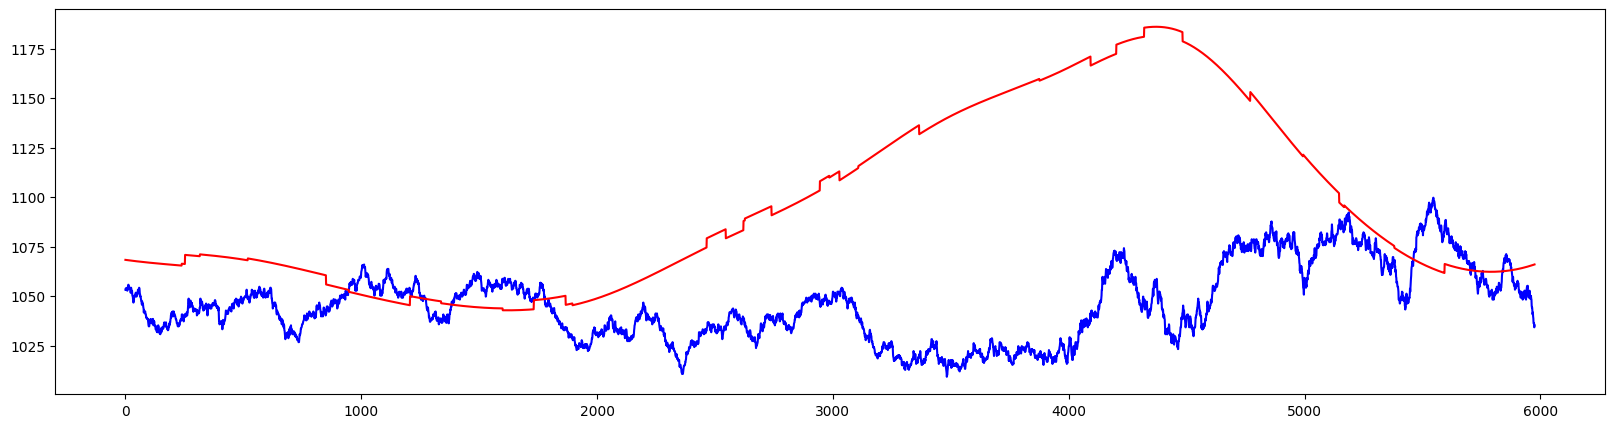

In [57]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.values, color="blue")
plt.plot(preds, color = "red")

print(model.coef_)

In [58]:
savgol_preds = data["savgol_price"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


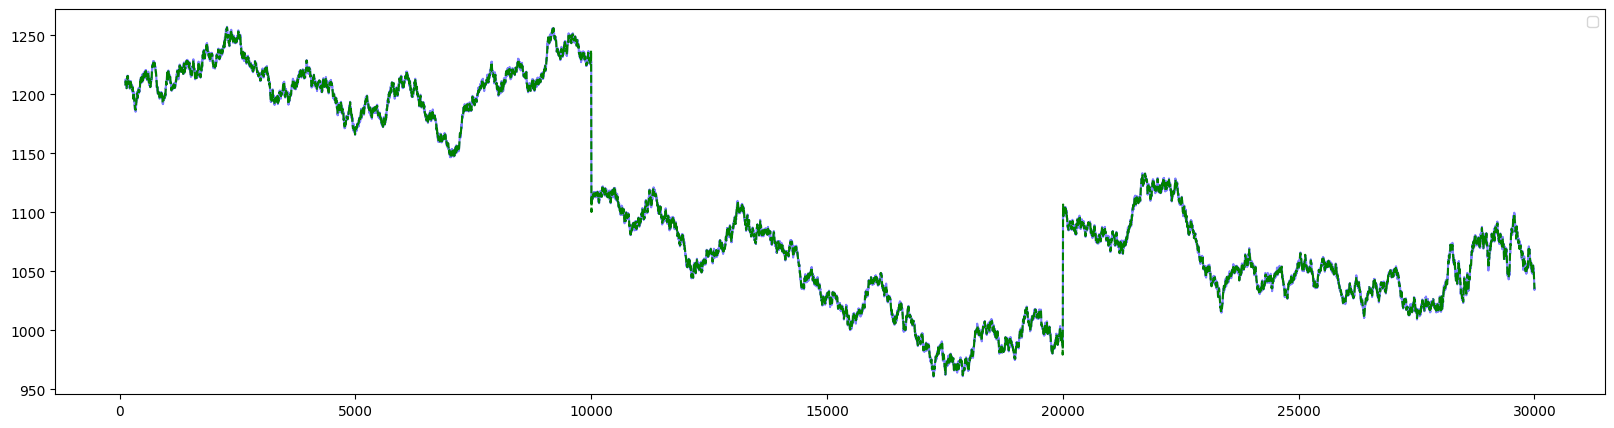

In [59]:
fig = plt.figure(figsize=(20,5))
plt.plot(data.ORCHIDS, color="blue", alpha=0.5)
plt.plot(data.savgol_price, color="green", linestyle="dashed")
plt.legend()

- Use the gradient of the curve to sell or buy if price is bellow or aboev predictions and slope close to 0

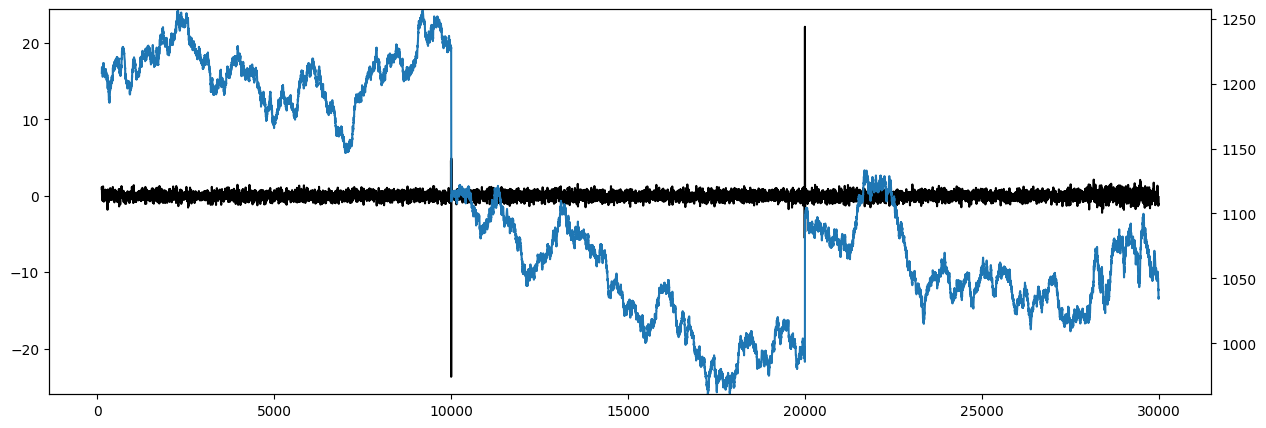

In [60]:
x = np.arange(0,len(savgol_preds))
dx = np.diff(x)
dy = np.diff(y)
d = np.gradient(savgol_preds)


fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()  
ax2.set_ylim(data.ORCHIDS.min(),data.ORCHIDS.max())
ax1.plot(data.savgol_gradient, color="black")
ax2.plot(y)

#plt.plot(savgol_preds)
savgol_signals = y

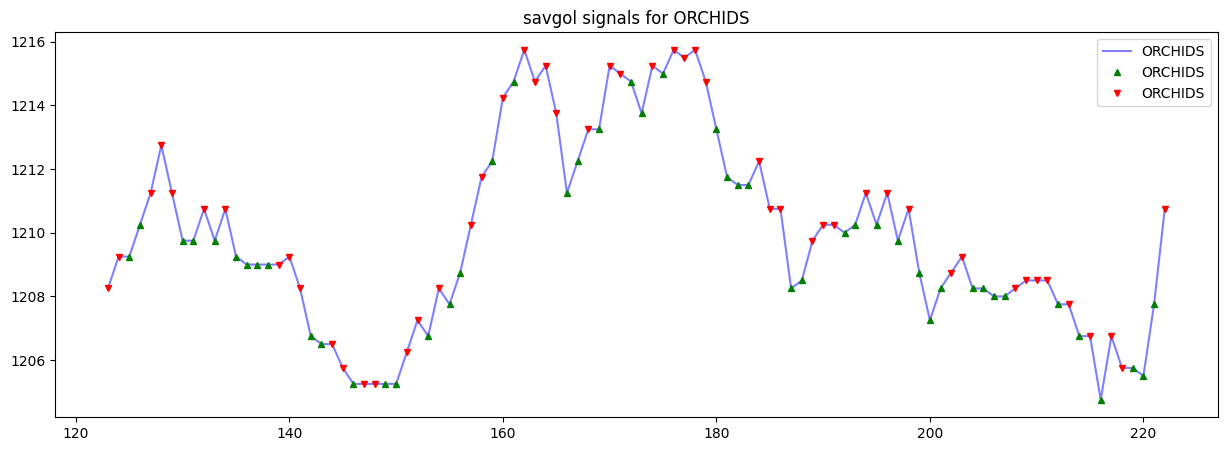

In [61]:
umbral_slope = 0.33
umbral_orchids = 100

# Aplicar filtro y crear la columna signal
data['signal_sell'] = np.where(
    
    (data['ORCHIDS'] > data["savgol_price"]),
    -1,
    0
)
data['signal_buy'] = np.where(
    (data['ORCHIDS'] < data["savgol_price"]),
    1,
    0
)
data = data[:100]
fig = plt.figure(figsize=(15,5))
data["ORCHIDS"].plot(color="blue", alpha=0.5)
data["ORCHIDS"][data.signal_buy==1].plot(marker="^", markersize=5, color='g',linestyle='')
data["ORCHIDS"][data.signal_sell==-1].plot(marker="v", markersize=5, color='r',linestyle='')
title = "savgol signals for ORCHIDS"
plt.legend()
plt.title(title)
plt.savefig(f"{CHARTS_DIR}/R2_{title}.jpg")

Use a classification model to find parameters of when to sell or buy with savgol signal

In [20]:
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier(alpha=1)
X = data.

SyntaxError: invalid syntax (819294999.py, line 4)

In [27]:
def calcular_returns(open_positions, order_depth):
    for product, orders in open_positions.items():
        close_orders = []
        position = {}
        best_bid, best_ask = next(iter(order_depth['buy_orders'])), next(iter(order_depth['sell_orders']))
        returns = 0
        for price, quant in open_positions[product].items():
            market_price = best_ask if quant > 0 else best_bid
            profit = ((market_price - price)/price) if quant >= 0 else ((market_price - price)/market_price)
            returns += profit * quant
        print(f"Returns for {product}: {returns}")

# Supongamos que tienes los siguientes datos de prueba:
open_positions = {
    'product1': 0,
    'product2': 1
}

order_depth = {
    'buy_orders': {4997: 10, 4998: 20},
    'sell_orders': {4999: 15, 5000: 25}
}

In [28]:
for i , prod in enumerate(open_positions.items()):
    print(prod[0])

d = {prod:[] for prod in open_positions.keys()}
print(d)

product1
product2
{'product1': [], 'product2': []}
